In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipwhois import IPWhois

pd.options.mode.chained_assignment = None  # default='warn'
dataset_fname = 'marx-geo.csv'

# Dataset

### Source

Rows summarize network packets (captured with `iptables`) for honeypots running
from March to September, 2013.

### Column descriptions:
* `datetime`: time packets were captured
* `host`: hostname for honeypot (destination)
* `src`: source IP (as integer)
* `srcstr`: source IP (as string)
* `spt`: source port
* `dpt`: destination port (on the host)
* `proto`: network protocol
* `type`: type code field
* `country`: country of source
* `cc`: short country code
* `locale`, `localeabbr`, `postalcode`, `latitude`, `longitude`: additional
geolocale details (based on source IP)

# Data preprocessing & cleaning
##### Skip this section if you are not interested in technical details

Some of the rows in the provided dataset contain an extra comma in the "locale" column without it being encased by any type of quotation character. As an example: "Washington, D.C." in the following entry:

2013-03-20 11:18:44,groucho-tokyo,1612338957,TCP,,56559,23,96.26.87.13,US,United States,Washington, D.C.,DC,,38.8951,-77.0364

We will address this by dropping the 11th comma for entries that have 15 instead of 14 commas

In [2]:
fixed_lines = []
with open(dataset_fname, "r") as f:
    for line in f:
        temp = line.replace("\n","").split(",")
        if len(temp) == 16:
            temp = temp[:10] + [temp[10] + temp[11]] + temp[12:]
            fixed_lines.append(temp)
        else:
            fixed_lines.append(temp)
            
df = pd.DataFrame(fixed_lines[1:], columns=fixed_lines[0])
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace = True)

In [3]:
print('Total number of entries:', len(df))
print('"Washington, D.C." issue fixed (for example: #30826):')
df.iloc[30825:30830].head()

Total number of entries: 451581
"Washington, D.C." issue fixed (for example: #30826):


,host,src,proto,type,spt,dpt,srcstr,cc,country,locale,localeabbr,postalcode,latitude,longitude
datetime,,,,,,,,,,,,,,
2013-03-20 11:18:25,groucho-tokyo,1118821529,TCP,,22513,5038,66.175.220.153,US,United States,New Jersey,NJ,08205,39.4899,-74.4773
2013-03-20 11:18:44,groucho-tokyo,1612338957,TCP,,56559,23,96.26.87.13,US,United States,Washington D.C.,DC,,38.8951,-77.0364
2013-03-20 11:19:09,groucho-oregon,3074353246,TCP,,54934,22,183.62.232.94,CN,China,Guangdong,44,,23.1167,113.25
2013-03-20 11:19:21,groucho-singapore,3736743325,TCP,,6000,6666,222.186.45.157,CN,China,Jiangsu Sheng,32,,32.0617,118.7778
2013-03-20 11:20:05,groucho-singapore,1867054121,TCP,,6000,1433,111.72.252.41,CN,China,Jiangxi Sheng,36,,28.55,115.9333


In [4]:
df.replace("", np.nan, inplace = True)
df['cc_locale'] = df['cc'] + '_' + df['localeabbr']
df['srcstr_proto'] = df['srcstr'] + ' ' + df['proto']

# Exploratory Data Analysis

### Technical details

Let's start by checking how sparse are different columns in our dataset and examining what data is missing:

In [5]:
print("Number of null values by column:\n")
print(df.isna().sum())

Number of null values by column:

host                 0
src                  0
proto                0
type            406770
spt              44811
dpt              44811
srcstr               0
cc                3595
country           3634
locale          109469
localeabbr      119842
postalcode      365144
latitude          3428
longitude         3428
cc_locale       119842
srcstr_proto         0
dtype: int64


In [6]:
print('Number of ICMP entries by type (top 5):')
print(df.groupby(['proto', 'type']).size().sort_values(ascending = False)[:5])
print('Sum of entries for all ICMP types adds up to the total number of ICMP entries:',
      sum(df.groupby(['proto', 'type']).size()) == len(df[df['proto'] == 'ICMP']) ) 

Number of ICMP entries by type (top 5):
proto  type
ICMP   8       38597
       3        4251
       11       1156
       0         536
       13        142
dtype: int64
Sum of entries for all ICMP types adds up to the total number of ICMP entries: True


In [7]:
print('Number of TCP/UP entries by source/destination ports (top 5):')
print(df.groupby(['proto', 'spt', 'dpt']).size().sort_values(ascending = False)[:5])
print('Sum of entries for all non-ICMP types adds up to the total number of non-ICMP entries:',
      sum(df.groupby(['proto', 'spt', 'dpt']).size()) == (len(df[df['proto'] == 'TCP']) +  len(df[df['proto'] == 'UDP']))) 

Number of TCP/UP entries by source/destination ports (top 5):
proto  spt    dpt  
TCP    6000   1433     95153
UDP    25416  56338    18195
TCP    6000   3306     13125
              3389     12795
UDP    10100  2193     11116
dtype: int64
Sum of entries for all non-ICMP types adds up to the total number of non-ICMP entries: True


In [8]:
df_subset = df[df['latitude'].isna()]

print("Number of entries with no geo information at all:", len(df_subset))
print("Out of these, the number of entries with src port = '67' and dest. port = '68':  ",
      len(df_subset[df_subset['spt'].isin(['67']) & df_subset['dpt'].isin(['68'])]))

Number of entries with no geo information at all: 3428
Out of these, the number of entries with src port = '67' and dest. port = '68':   1712


From Wikipedia:
* port 67 is used by Bootstrap Protocol (BOOTP) server, also by Dynamic Host Configuration Protocol (DHCP) 
* port 68 is used by Bootstrap Protocol (BOOTP) client, also by Dynamic Host Configuration Protocol (DHCP) 

### High level summary of missing data

A cursory look at the dataset shows us that:

* Basic information (host, source IP, network protocol) is populated for all entries
* Large number of entries is missing some geolocale details (for example local postal code), but almost all have basic (country, latitude & longitude) data.
* Less than 1% of entries is missing basic geolocale (latitude and longitude) information, half of these entries are for source port 67 / destination port 68
* All ICMP entries have type field populated
* All TCP & UDP entries have source/destination port fields populated


### Histograms for key columns of interest

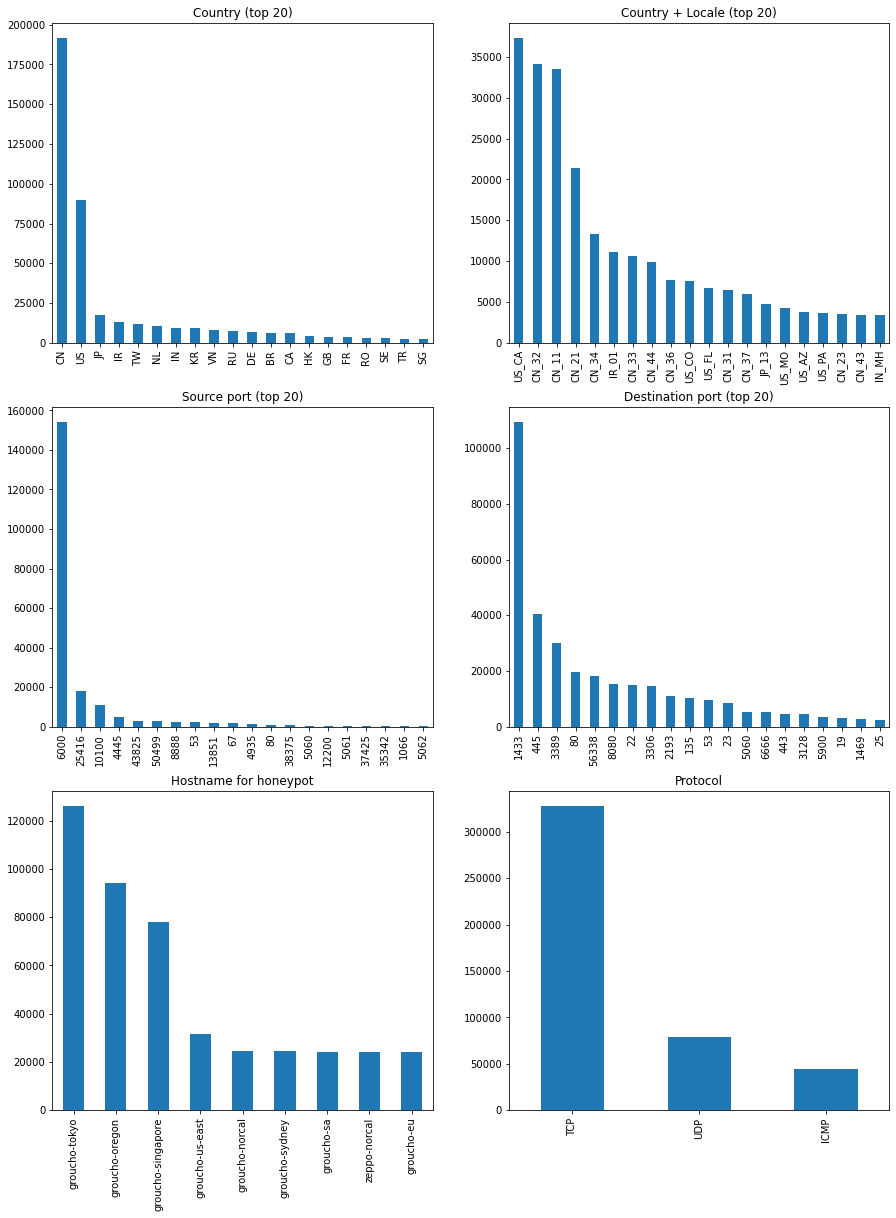

In [9]:
fig, axes = plt.subplots(nrows = 3, ncols = 2)

fig.set_figheight(20)
fig.set_figwidth(15)
df['cc'].value_counts()[:20].plot(ax=axes[0, 0], kind = 'bar', title = 'Country (top 20)')
df['cc_locale'].value_counts()[:20].plot(ax=axes[0, 1], kind = 'bar', title = 'Country + Locale (top 20)')
df['spt'].value_counts()[:20].plot(ax=axes[1, 0], kind = 'bar', title = 'Source port (top 20)')
df['dpt'].value_counts()[:20].plot(ax=axes[1, 1], kind = 'bar', title = 'Destination port (top 20)')
df['host'].value_counts().plot(ax=axes[2, 0], kind = 'bar', title = 'Hostname for honeypot')
df['proto'].value_counts().plot(ax=axes[2, 1], kind = 'bar', title = 'Protocol')

Overall, we have a diverse mix of data containing TCP, UDP, and ICMP traffic to 9 geographically distributed honeypots coming from a variety of countries with China and US being the top sources.

# Data insights

Let's examine trends in this dataset in more detail and see if we can find any unusual or potentially concerning traffic patterns

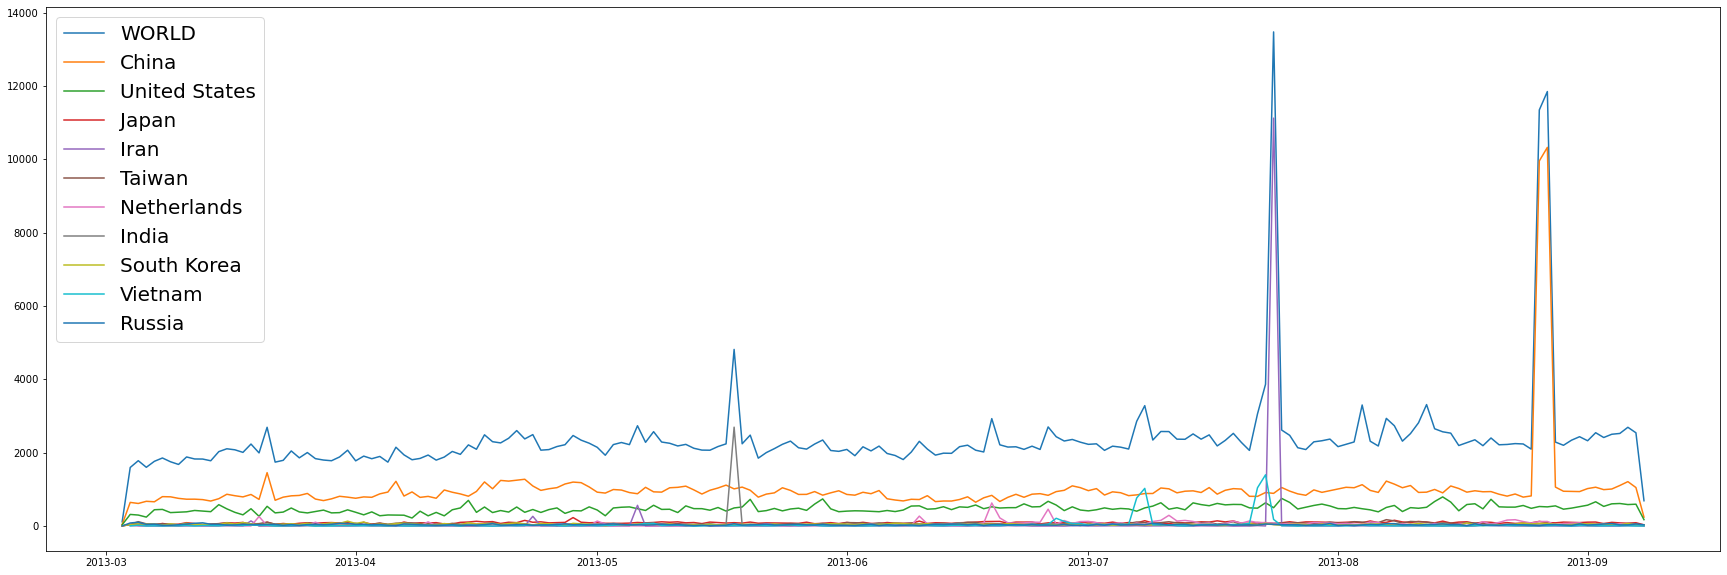

In [10]:
top_x_countries = 10
selections = df['country'].value_counts()[:top_x_countries].index.tolist()
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)

plt.plot(df.resample('D').agg('size'), label = 'WORLD')
for i, country in enumerate(selections): 
    plt.plot(df[df['country'] == country].resample('D').agg('size'), label = country)

plt.legend(loc = 2, prop={'size': 20})
plt.show()

As we can see, there were several substantial activity spikes, with 3 largest originating from China (late August spike), Iran (late July spike), and India (mid May). Let's have a quick look at the protocols associated with these spikes:

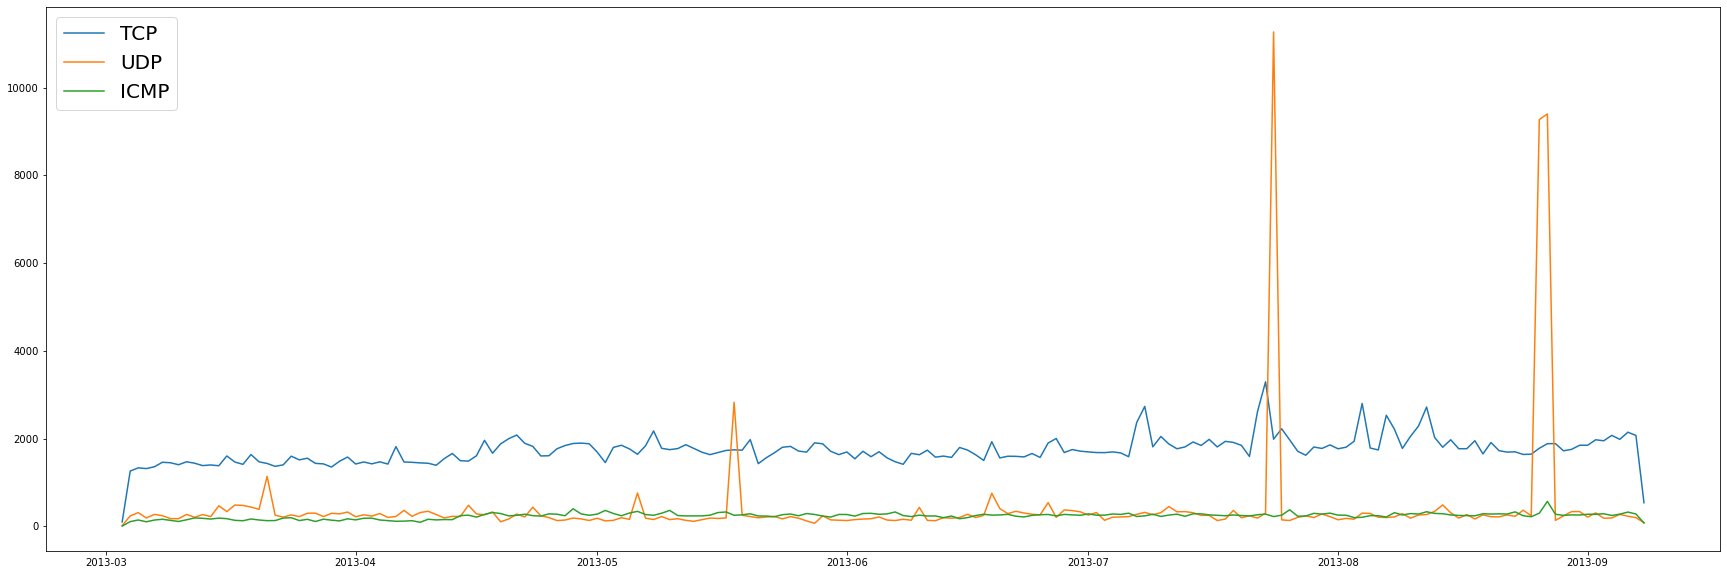

In [11]:
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)

for i, prot in enumerate(df['proto'].unique()): 
    plt.plot(df[df['proto'] == prot].resample('D').agg('size'), label = prot)

plt.legend(loc = 2, prop={'size': 20})
plt.show()

These large spikes were driven by upticks in UDP traffic - potential UDP flood (DDOS) attempts? Or maybe a result of network misconfiguration?

Finally, let's check if honeypots were indiscriminately probed, or only a specific one was targeted:

Country =  China


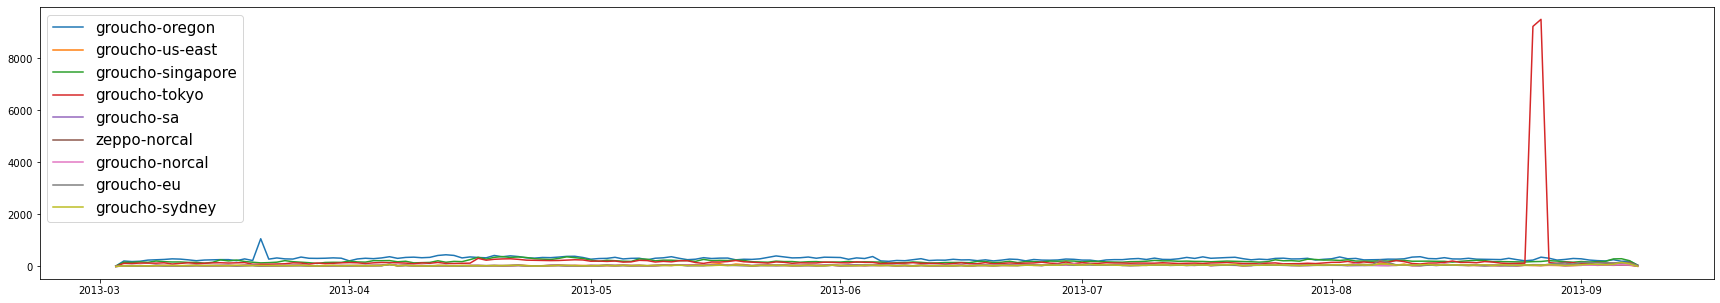

Country =  Iran


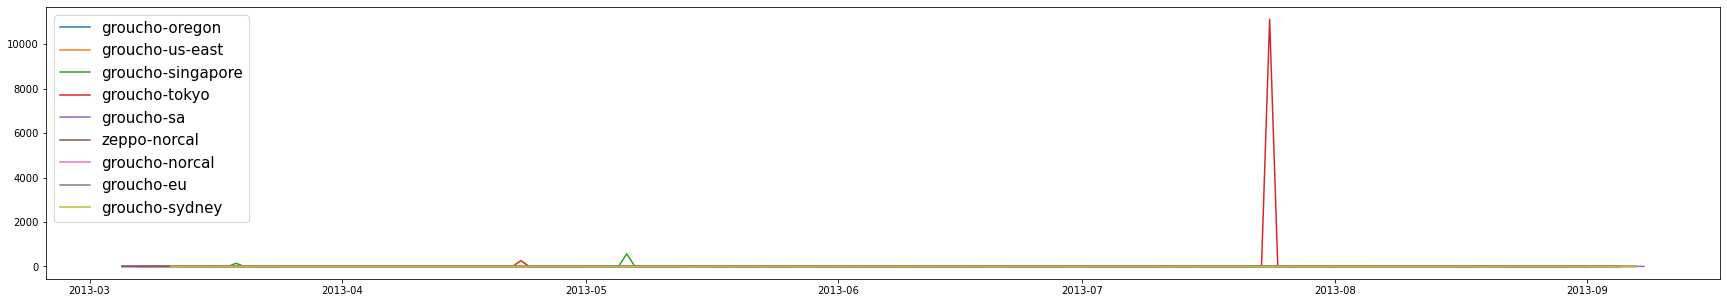

Country =  India


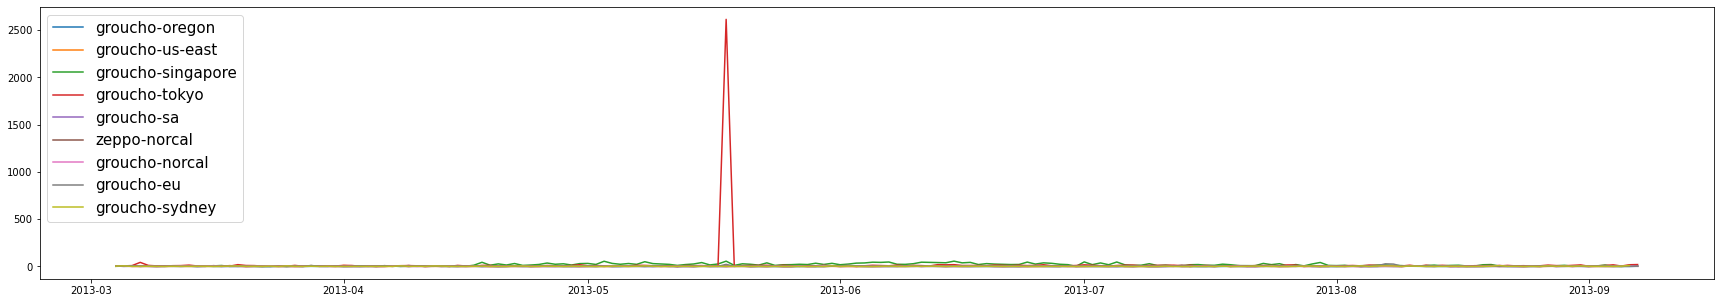

In [12]:
countries_to_plot = ['China','Iran','India']

hosts = list(df['host'].unique())
for sel_country in countries_to_plot:
    print('Country = ', sel_country)
    df_subset = df[df['country'] == sel_country]
    fig, ax = plt.subplots()
    fig.set_figwidth(30)
    fig.set_figheight(5)
    
    for val in hosts: 
        plt.plot(df_subset[df_subset['host'] == val].resample('D').agg('size'), label = val)

    plt.legend(loc = 2, prop = {'size': 15})
    plt.show()

Groucho-tokyo was the target in all 3 cases.
We can get additional insights into these and other incidents by looking at specific IPs involved, as well as by looking at *cumulative* traffic by top IPs for each of these 3 countries. 

In [13]:
def plot_time_trends(df, by_col, cumplot, resample_rate, fig_h, num_of_top_entries, split_on_ith_el):
    
    if len(split_on_ith_el) > 0:
        split_on_ith_el = [0] + split_on_ith_el + [num_of_top_entries]
        
    groups = list(df[by_col].value_counts()[:num_of_top_entries].index.tolist())

    for ind in range(1, max(2, len(split_on_ith_el))):

        fig, ax = plt.subplots()
        fig.set_figwidth(30)
        fig.set_figheight(fig_h)
        if split_on_ith_el:
            prev_i = split_on_ith_el[ind - 1]
            split_i = split_on_ith_el[ind]
        else:
            prev_i, split_i = 0, num_of_top_entries
        print(f'Top {num_of_top_entries } entries: from #{prev_i + 1} to #{split_i}')
        for val in groups[prev_i : split_i]: 
            y = df[df[by_col] == val].resample(resample_rate).agg('size')
            if cumplot: y = y.cumsum()
            plt.plot(y, label = val)

        plt.legend(loc = 2, prop = {'size': 15})
        plt.show() 
    

Country =  China
Top 10 entries: from #1 to #10


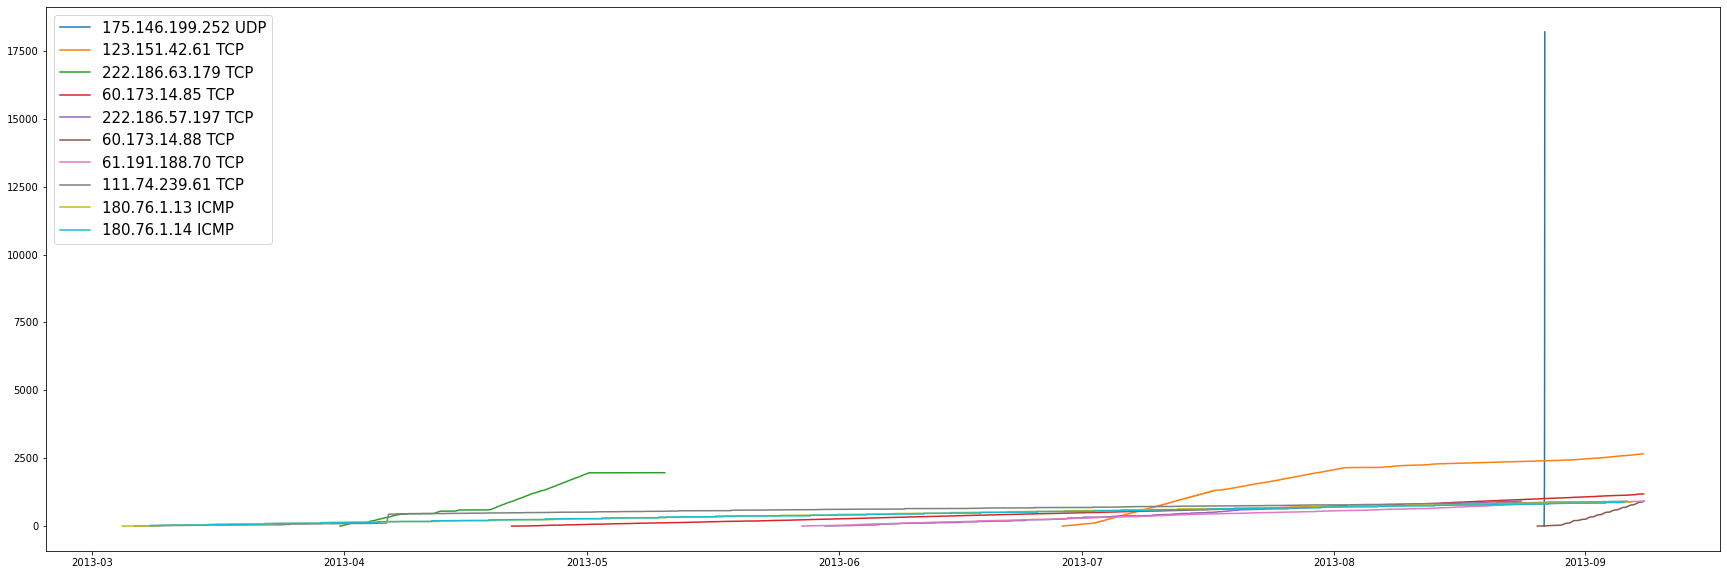

Country =  Iran
Top 10 entries: from #1 to #10


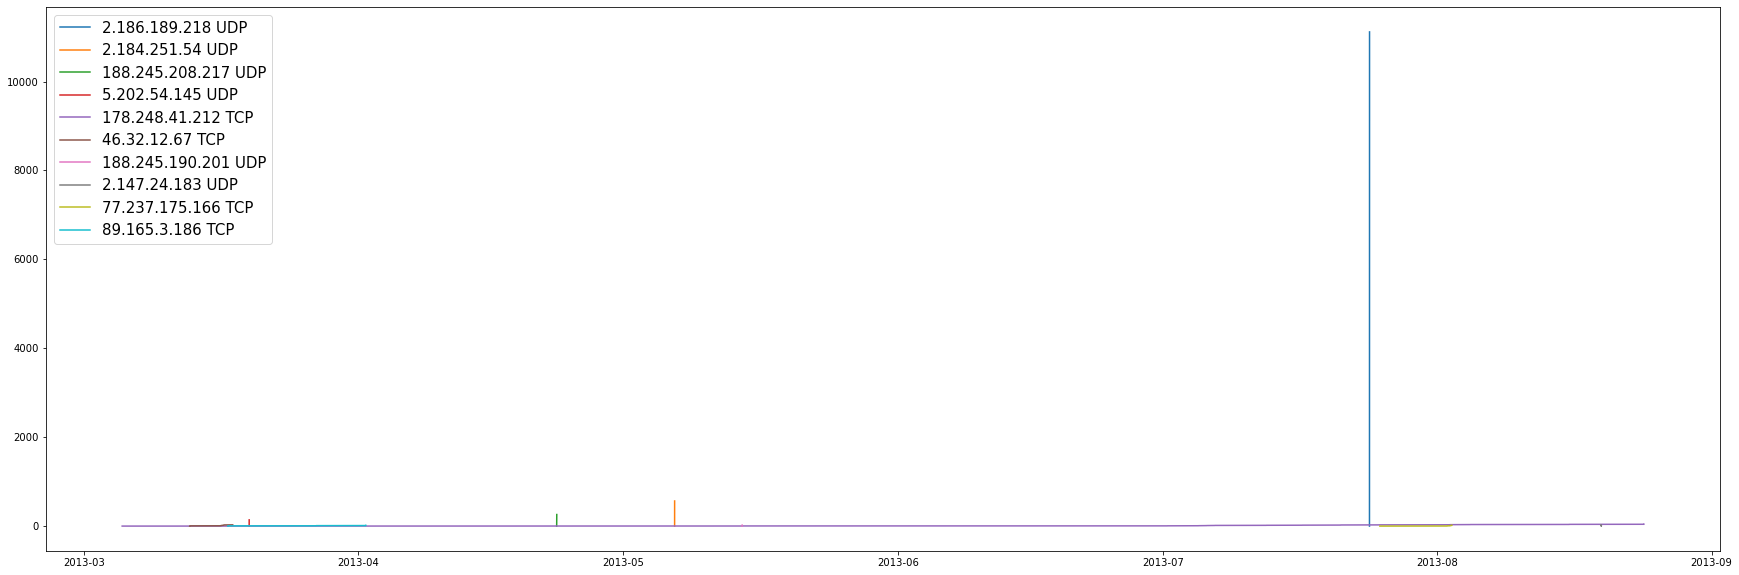

Country =  India
Top 10 entries: from #1 to #10


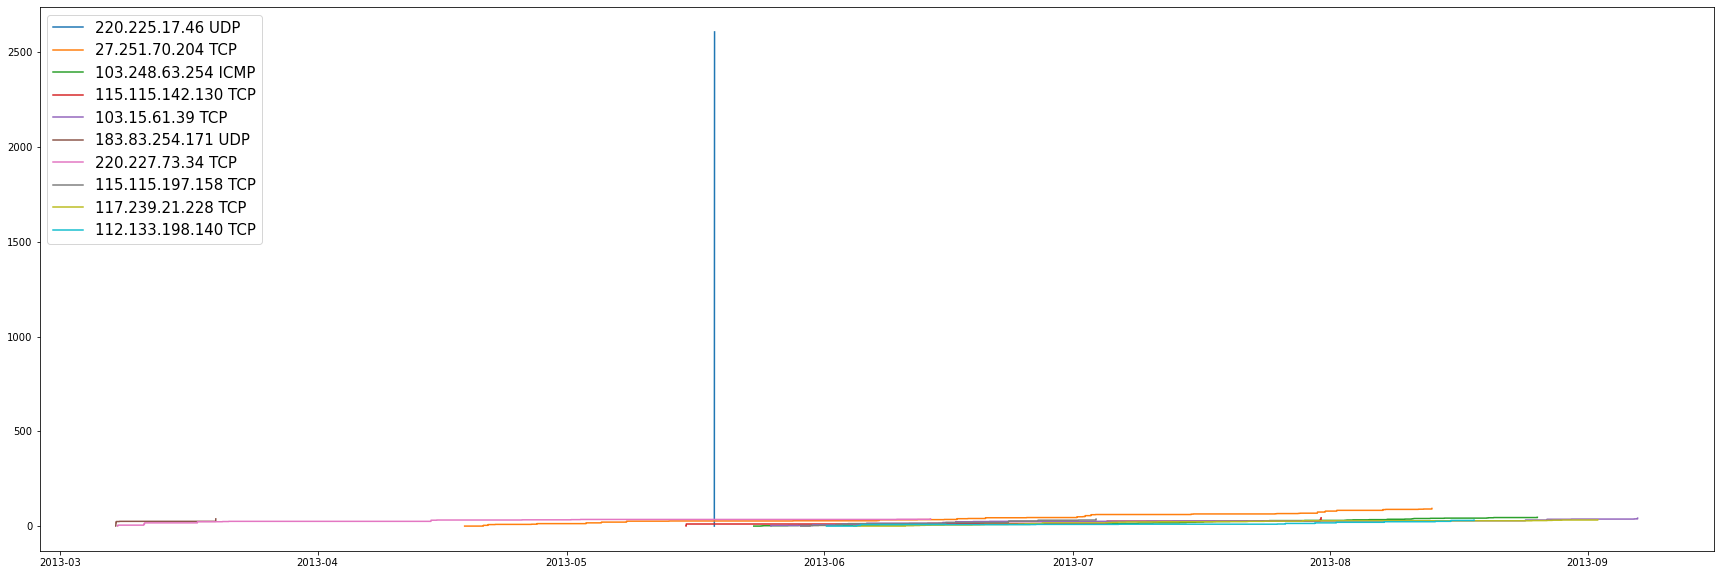

In [14]:
countries_to_plot = ['China', 'Iran', 'India']

for sel_country in countries_to_plot:
    print('Country = ', sel_country)
    df_subset = df[df['country'] == sel_country]
    
    plot_time_trends(df = df_subset, by_col = "srcstr_proto", cumplot = True, resample_rate = 'S', fig_h = 10, 
                     num_of_top_entries = 10, split_on_ith_el = [])

In [15]:
ips_with_UDP_traffic_spikes = ['175.146.199.252', '2.186.189.218', '220.225.17.46']
df_subset = df[df['srcstr'].isin(ips_with_UDP_traffic_spikes)]
df_subset.groupby(['srcstr','spt', 'dpt']).size()

srcstr           spt    dpt  
175.146.199.252  25416  56338    18195
2.186.189.218    10100  2193     11116
220.225.17.46    50499  1469      2605
dtype: int64

As we can see, in all 3 cases, the traffic spikes are associated with a single IP/ports combo (different in each incident).

In addition to these short bursts of traffic, we see a couple of IPs gradually generating large amount of traffic over a longer time period. Such behavior may (or may not) be indicative of them trying to scan our network, so we'll have a closer look at these IPs. We will exclude the abrupt traffic spikes we focused on previously, and look at the rest of the top IPs to see if we'll see more of such not short burst-related activity. Let's start with the U.S. and China:

Country =  United States
Top 20 entries: from #1 to #20


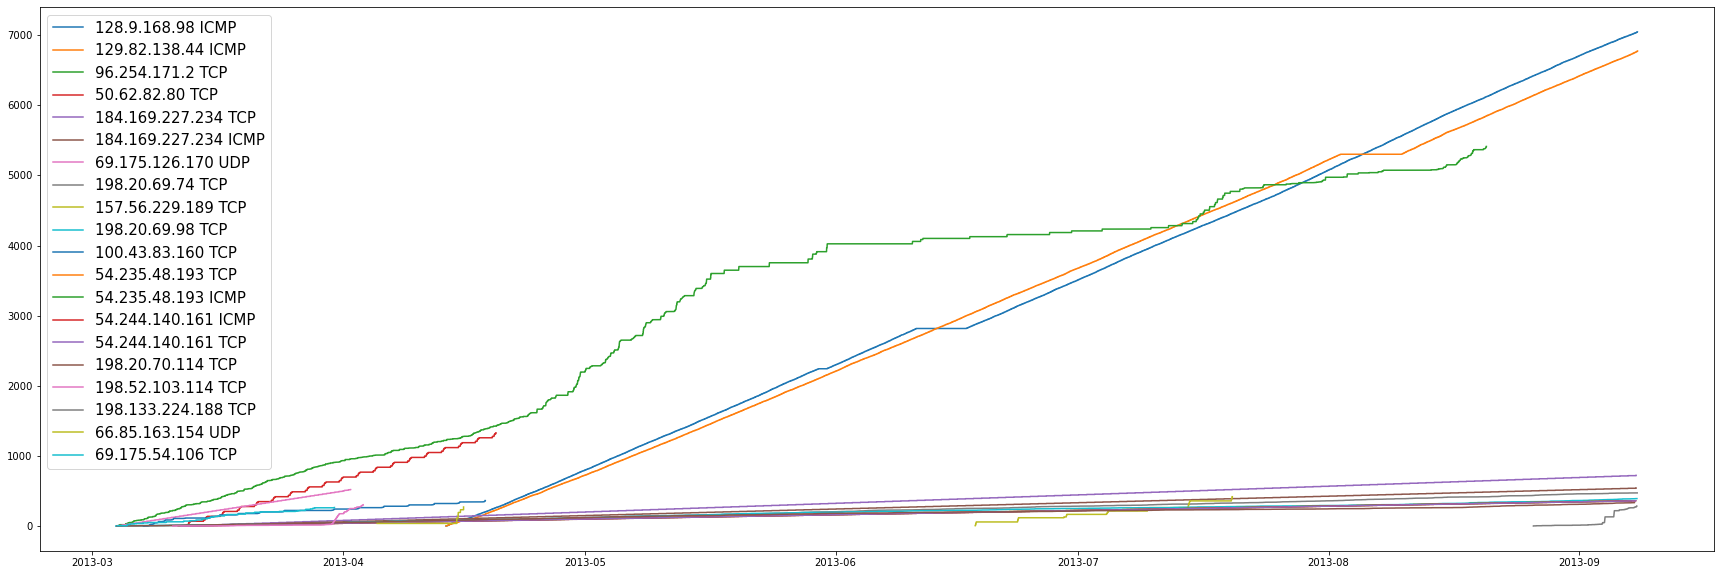

Country =  China
Top 20 entries: from #1 to #20


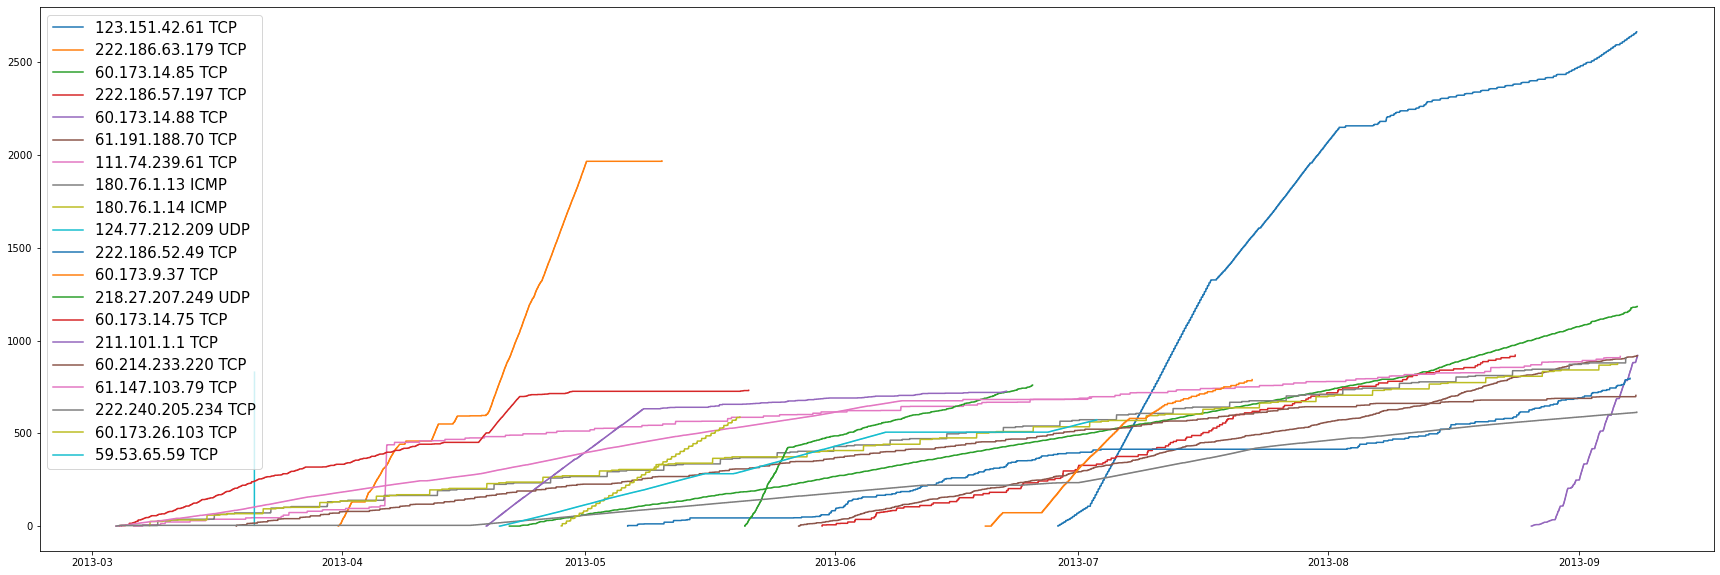

In [16]:
countries_to_plot = ['United States', 'China']

for sel_country in countries_to_plot:
    print('Country = ', sel_country)
    df_subset = df[df['country'] == sel_country]
    if sel_country == 'China': df_subset = df_subset[df_subset['srcstr'] != '175.146.199.252']

    plot_time_trends(df = df_subset, by_col = "srcstr_proto", cumplot = True, resample_rate = 'min', fig_h = 10, 
                     num_of_top_entries = 20, split_on_ith_el = [])

Several notable trends can be seen in the plots above: 
* some IPs are maintaining an almost constant traffic rate throughout the whole time period represented in the dataset
* some IPs have "elbow-shaped" cumulative curves: they start in a high traffic state until they hit a certain moment or threshold; after that they switch to a lower (but non-zero!) traffic state and can remain in that state for a long period of time
* there are also IPs with staircase-shaped cumulative curves, some of them moving in lockstep with each other (for example ICMP traffic from 180.76.1.13 & 180.76.1.14)

Each of these trends may be worth exploring in more detail, but for the purpose of this exercise we will have a closer look at ICMP traffic (from all countries), with particular focus on the curves with staircase shaped cumulative curves.

In [17]:
df_subset = df[df['proto'] == 'ICMP'] 
df_subset['srcstr_ICMPtype'] = df_subset['srcstr'] + " (" + df_subset['country'] + ")"\
                            + ' ICMP type = ' + df_subset['type']

df_subset['srcstr_ICMPtype_host'] = df_subset['srcstr_ICMPtype'] + ', ' + df_subset['host']

Largest sources of ICMP traffic:
Top 20 entries: from #1 to #3


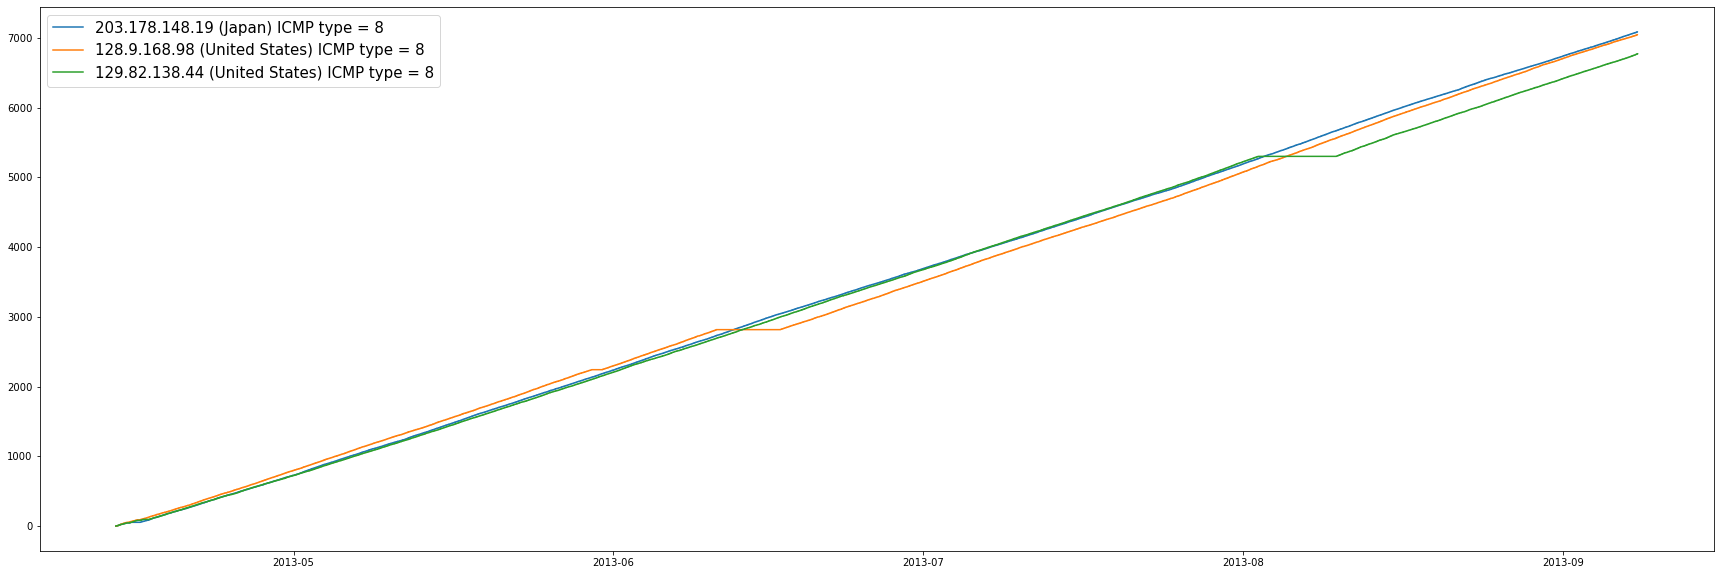

Top 20 entries: from #4 to #20


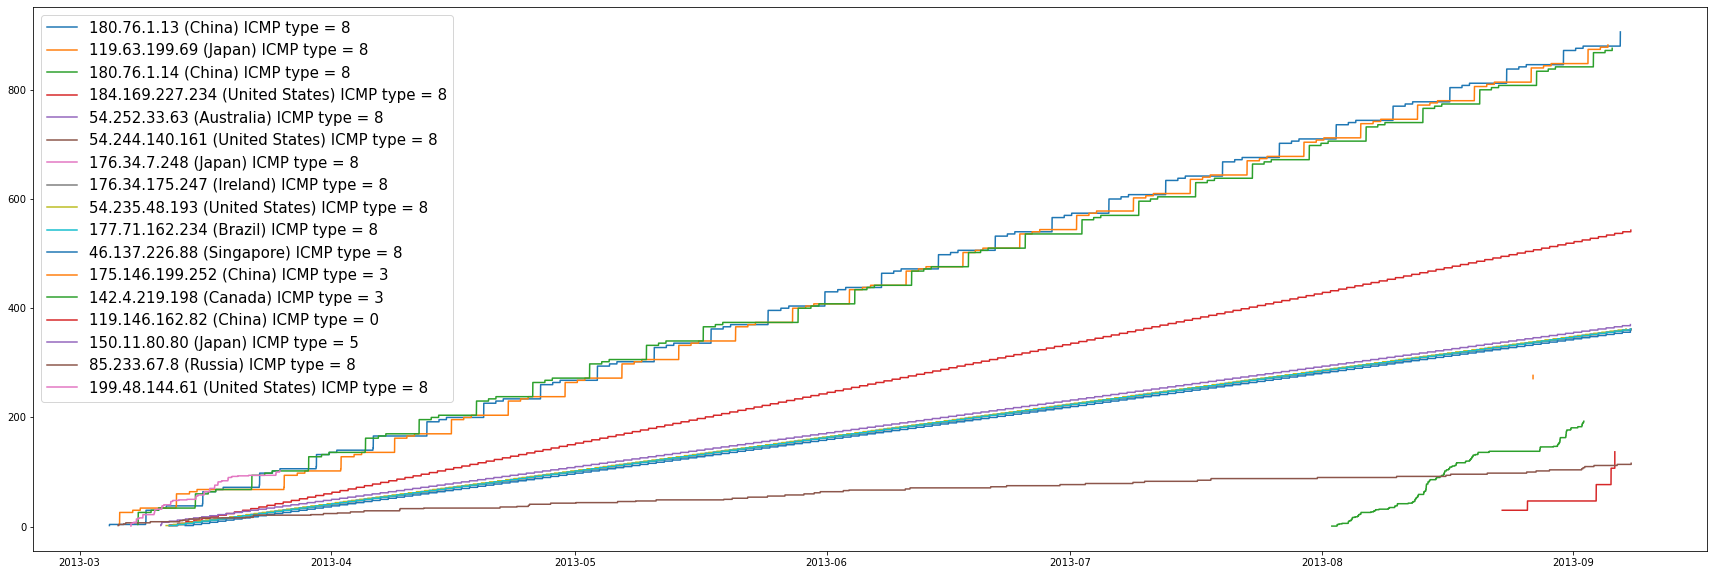

In [18]:
print('Largest sources of ICMP traffic:')
plot_time_trends(df = df_subset, by_col = "srcstr_ICMPtype", cumplot = True, resample_rate = 'min', fig_h = 10, 
                 num_of_top_entries = 20, split_on_ith_el = [3])

There are quite a few groups of highly correlated cumulative trends, let's have an even closer look and also group the data by host / honeypot names:

Largest sources of ICMP traffic (incl. grouping by host):
Top 30 entries: from #1 to #6


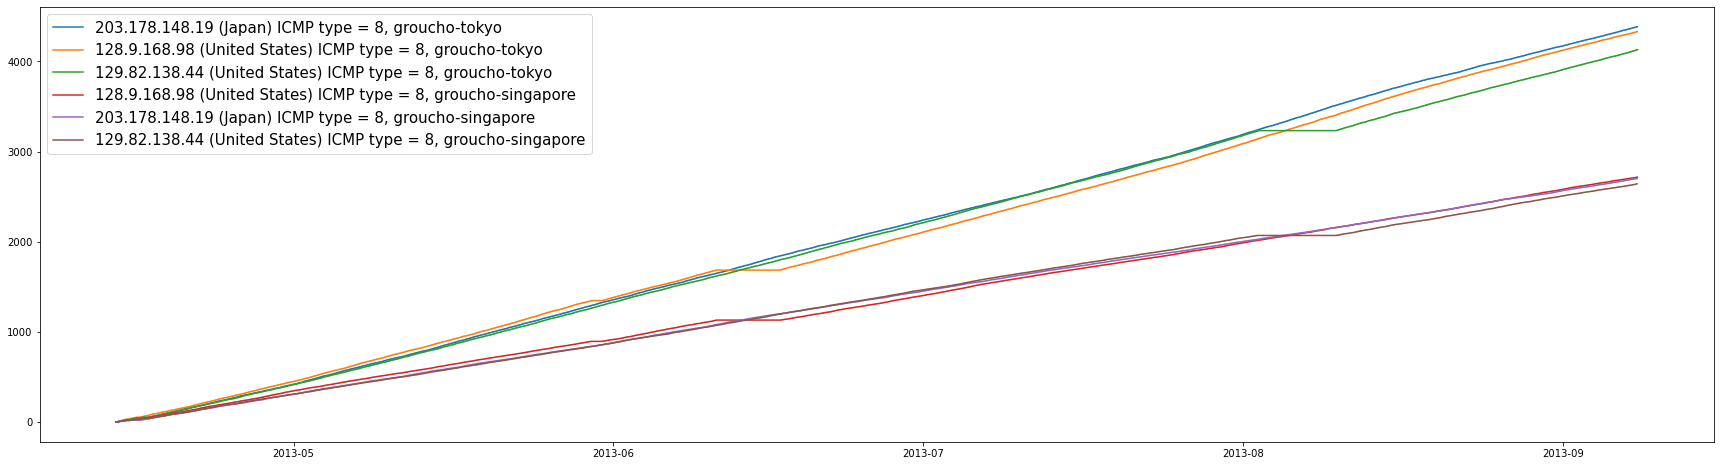

Top 30 entries: from #7 to #10


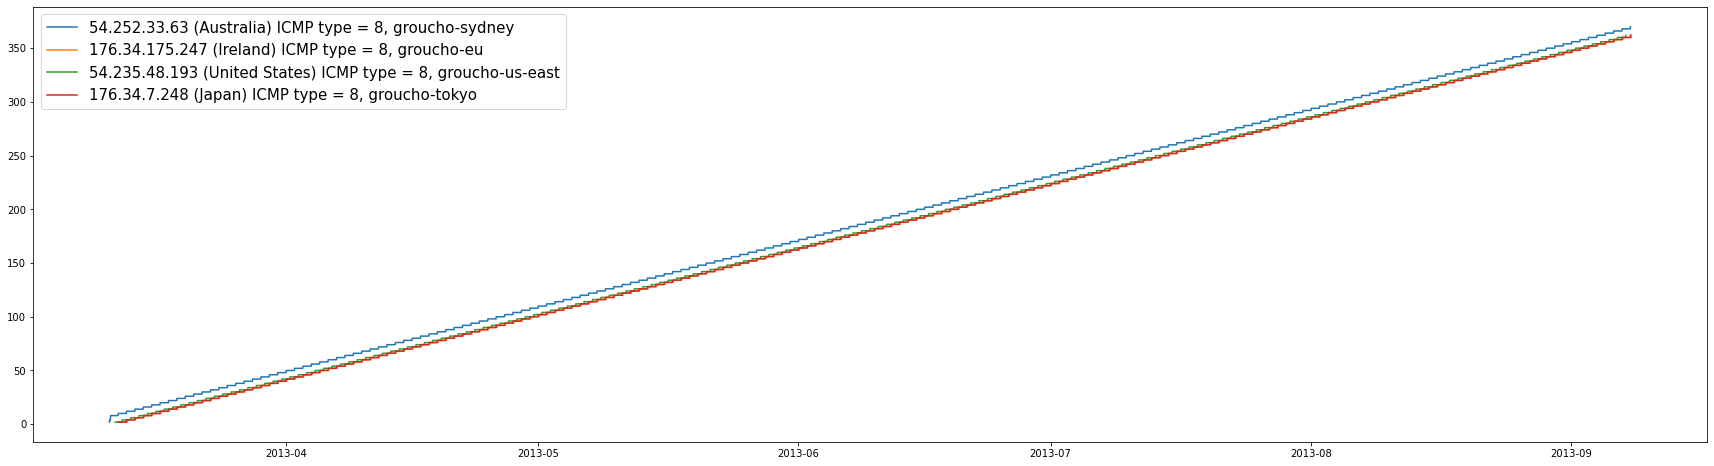

Top 30 entries: from #11 to #12


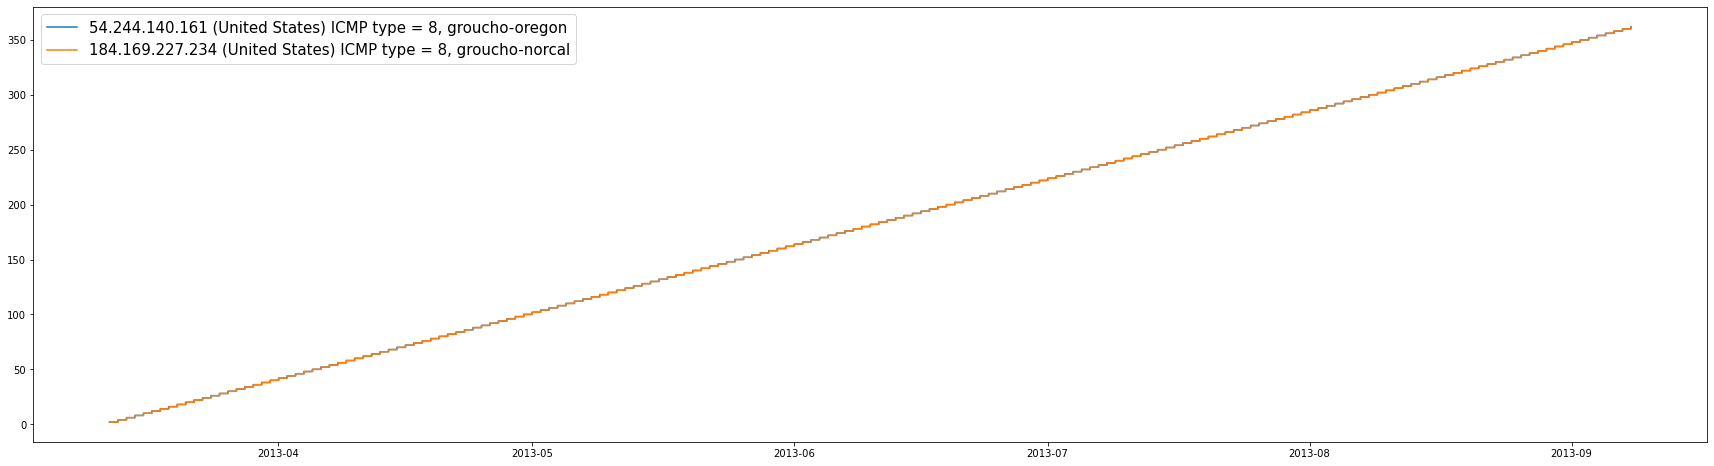

Top 30 entries: from #13 to #16


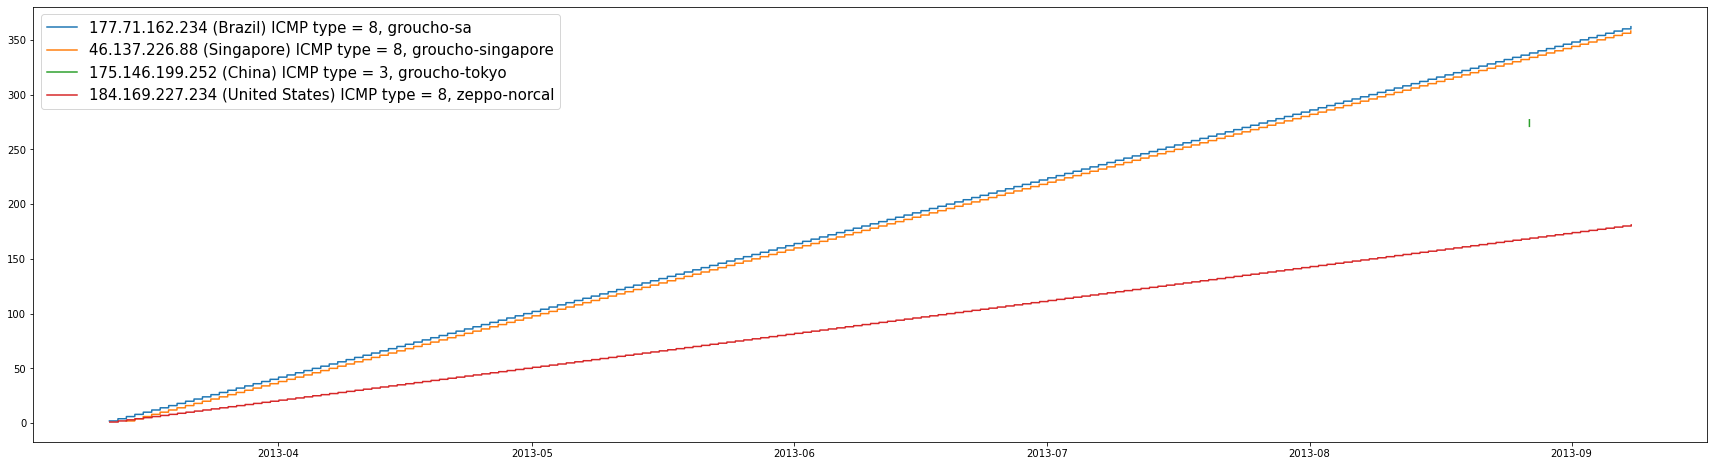

Top 30 entries: from #17 to #30


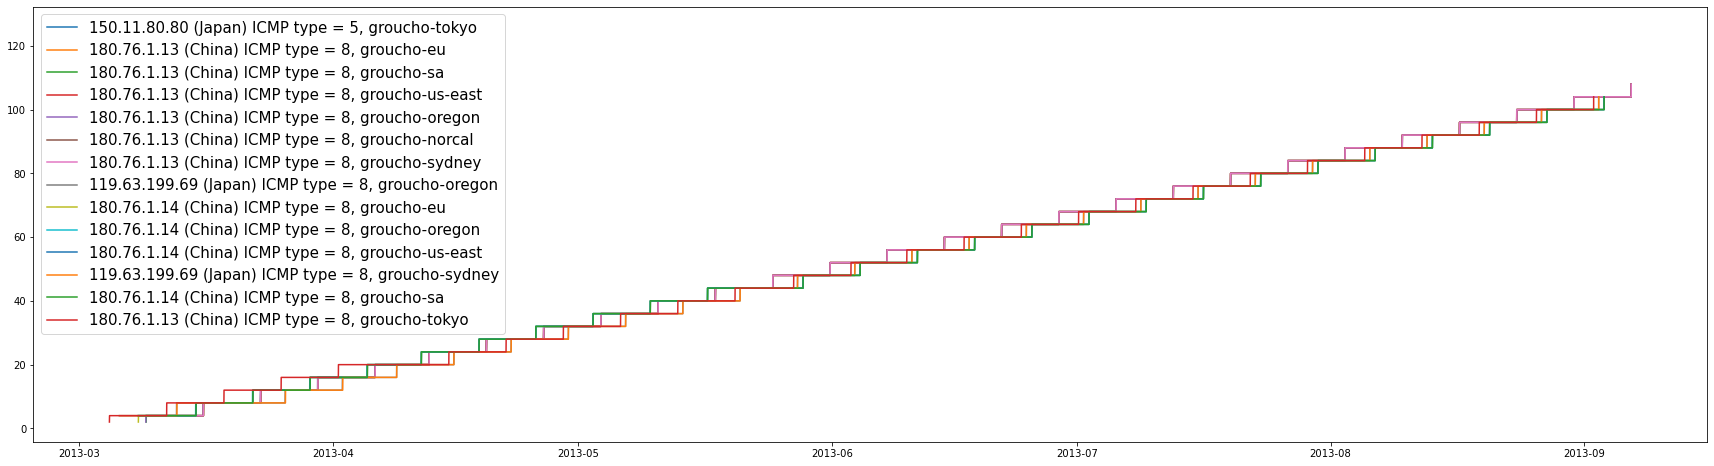

In [19]:
print('Largest sources of ICMP traffic (incl. grouping by host):')
plot_time_trends(df = df_subset, by_col = "srcstr_ICMPtype_host", cumplot = True, resample_rate = 'min', fig_h = 8,
                 num_of_top_entries = 30, split_on_ith_el = [6, 10, 12, 16])

#### Key insights from the above trends
* Many of them (not all!) tend to favor the geographically closest honeypot (e.g. australian IP -> groucho-sydney, irish IP -> groucho-eu)
* A group of Chinese IPs (180.76.1.13 & 180.76.1.14) seems to indiscriminately probe multiple honeypots with roughly the same frequency
* groucho-tokyo attracts above average amount of attention not just from japanese IPs and the aforementioned Chinese IP group, but also from the US. To a somewhat lesser extent that's true for groucho-singapore as well.

By this point, we've identified a couple of a potentially interesting IP addresses, so let's check who do they belong to:

In [20]:
def get_assignee_name(ip_addr_str):
    obj = IPWhois(ip_addr_str) # e.g. '123.151.42.61'
    result = obj.lookup_rdap(depth = 1)
    return result['asn_description']

top_3_icmp_traffic_ips = ['203.178.148.19','128.9.168.98', '129.82.138.44']
chinese_ips_with_multi_host_icmp_probing = ['180.76.1.14', '180.76.1.13']

In [21]:
print('IPs that generated massive UDP traffic spikes:')
for ip_addr in ips_with_UDP_traffic_spikes:
    print(ip_addr, ' assigned to ', get_assignee_name(ip_addr))

IPs that generated massive UDP traffic spikes:
175.146.199.252  assigned to  CHINA169-BACKBONE CHINA UNICOM China169 Backbone, CN
2.186.189.218  assigned to  TCI, IR
220.225.17.46  assigned to  RELIANCE-COMMUNICATIONS-IN Reliance Communications Ltd.DAKC MUMBAI, IN


In [22]:
print('IPs with the largest amount of ICMP traffic:')
for ip_addr in top_3_icmp_traffic_ips:
    print(ip_addr, ' assigned to ', get_assignee_name(ip_addr))

IPs with the largest amount of ICMP traffic:
203.178.148.19  assigned to  WIDE-BB WIDE Project, JP
128.9.168.98  assigned to  ISI-AS, US
129.82.138.44  assigned to  COLORADOSTATEUNIV, US


In case you were, like me, a little surprised by these results, here is a two-sentence introduction for each of these organisations:

WIDE project (from Wikipedia: https://en.wikipedia.org/wiki/WIDE_Project):

The WIDE Project (Widely Integrated Distributed Environment), is an Internet project in Japan founded by Keio University, Tokyo Institute of Technology, and The University of Tokyo. It runs a major backbone of the Japanese Internet and used to run the .jp Top Level Domain (TLD).

ISI / ANT labs (from their site: https://ant.isi.edu/about/index.html):

The ANT Lab is a research group spanning several departments at the University of Southern California (USC), Colorado State University, and Los Alamos National Laboratory; its goal is to improve the Internet by discovering new ways to understand network topology, traffic use and abuse.


In [23]:
print('Chinese IPs pinging multiple hosts:')
for ip_addr in chinese_ips_with_multi_host_icmp_probing:
    print(ip_addr, ' assigned to ', get_assignee_name(ip_addr))

Chinese IPs pinging multiple hosts:
180.76.1.14  assigned to  BAIDU Beijing Baidu Netcom Science and Technology Co., Ltd., CN
180.76.1.13  assigned to  BAIDU Beijing Baidu Netcom Science and Technology Co., Ltd., CN


So, these IPs could be associated with Baidu's web crawler/spider.

# Summary and potential next steps

Overall, the provided dataset can be used for high-level monitoring of network access patterns, flagging various irregularities in the traffic, and identifying sources of potentially undesirable or suspicious behavior.

#### A brief summary of initial takeaways
We have observed several events which may be worth look investigating in more detail:

* Three abrupt spikes in UDP traffic to groucho-tokyo host originating from three different telecom companies: China Unicom (late August), Telecom Company of Iran (late July), and Reliance Communications (India, mid May).
* Multiple IPs continuously pinging (ICMP traffic, type code 8) some hosts over prolonged periods of time. IPs with the highest volume (almost by an order of magnitude) are assigned to the Japan-based WIDE project and U.S.-based ANT lab and the affiliated Universities: Colorado State U and University of Southern California. 
* Additionally, we have seen high volume of ICMP pings coming from IPs assigned to Baidu. Unlike with the traffic from the aforementioned research labs, these pings were not particularly selective - large number of different hosts were pinged with roughly the same frequency.

#### Avenues for further investigation
* Analyze TCP traffic in more detail, the same way we did with ICMP traffic and UDP spikes
* Filter out high-traffic sources and focus on other, more subtle trends (some attack types may not generate massive amount of traffic!)
* A more formal analysis of sequence patterns: 
    * the same IP accessing ports/hosts in a certain sequence
    * groups of IPs probing one or multiple hosts around the same time
    * mathematically formalize the findings to detect such patterns without having a human analyst in the loop
* Explore alternative ways to look at the data. For example, we have seen various repetitive/periodic patterns in the data, so FFT and analysis in the frequency domain could be worth looking into.